# STAT207 Mini-Project #2 - College Basketball Power Rating Predictor


Alfred Hofmann

In [1]:
#Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore scikit-learn ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Introduction

### Research Goal Statement

The primary research goal that we are pursuing is to build a predictive model that will effectively predict the power rating of a men's college basketball team for new datasets.
Our secondary research goal is to yield reliable interpretative insights
about the nature of the relationship between the variables in the dataset.

### Research Motivation

It's currently March as I'm writing this, and Illinois just made the Elite Eight in the March Madness Men's College Basketball tournament. For college basketball fans, looking at statistics is a great way to measure a teams ability and gauge how good a certain team might be. While filling out brackets whether for fun or if you're in a bracket pool, it might be beneficial to know how good a team is and also what makes them good. The "power rating" of a team is an good overall measure of how good a team is, and it is defined as the probability of the team beating an "average" D1 team. It might be useful for say, an Illinois fan, to see how much specific characteristics of the team lead to giving us a higher power rating. For example, Illinois has a great offense, so seeing how much a great offense matters in predicting the power rating could be particularly insightful.

## 2. Dataset Discussion

### Dataset Display

Let's take a look at the first few rows of the dataset.

In [2]:
original_df = pd.read_csv('cbb24.csv')
original_df.head()

RK         TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG%  EFGD%  ...  \
0   1      Houston  B12  34  30  119.2   85.5   0.9785  49.7   44.0  ...   
1   2  Connecticut   BE  34  31  127.1   93.6   0.9712  57.1   45.1  ...   
2   3       Purdue  B10  33  29  126.2   94.7   0.9644  56.0   47.7  ...   
3   4     Iowa St.  B12  34  27  113.6   86.5   0.9583  51.9   47.1  ...   
4   5       Auburn  SEC  34  27  120.7   92.1   0.9573  54.1   43.4  ...   

    DRB   FTR  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  SEED  
0  30.2  29.9  39.0  48.4  43.4  34.7  30.0   63.3  10.6   1.0  
1  26.8  33.3  32.5  58.5  43.7  36.7  31.9   64.6  11.3   1.0  
2  24.7  42.8  23.0  53.2  48.1  40.8  31.4   67.6  11.0   1.0  
3  29.4  36.1  35.2  51.7  46.9  34.9  31.5   67.6   6.9   2.0  
4  30.3  38.2  41.0  54.9  42.8  35.2  29.8   69.8   5.5   4.0  

[5 rows x 23 columns]

We also want to see the original number of rows in this dataset before any data cleaning.

In [3]:
original_rows = original_df.shape[0]
print(f'Original number of rows: {original_rows}')

Original number of rows: 362


### Dataset Source

I found this dataset on [Kaggle](https://www.kaggle.com). Here is a link to the dataset: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?resource=download

I downloaded this dataset on March 29, 2024.

## 3. Dataset Cleaning

### General Data Cleaning

First, I want to take a look at the explanatory variables I want to include in this analysis.

In [4]:
original_df.columns

Index(['RK', 'TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG%',
       'EFGD%', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D',
       '3P_O', '3P_D', 'ADJ_T', 'WAB', 'SEED'],
      dtype='object')

RK (Only in cbb20): The ranking of the team at the end of the regular season according to barttorvik  

TEAM: The Division I college basketball school  

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)  

G: Number of games played  

W: Number of games won  

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)  

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)  

BARTHAG: Power Rating (Chance of beating an average Division I team)  

EFG_O: Effective Field Goal Percentage Shot  

EFG_D: Effective Field Goal Percentage Allowed  

TOR: Turnover Percentage Allowed (Turnover Rate)  

TORD: Turnover Percentage Committed (Steal Rate)  

ORB: Offensive Rebound Rate  

DRB: Offensive Rebound Rate Allowed  

FTR : Free Throw Rate (How often the given team shoots Free Throws)  

FTRD: Free Throw Rate Allowed  

2P_O: Two-Point Shooting Percentage  

2P_D: Two-Point Shooting Percentage Allowed  

3P_O: Three-Point Shooting Percentage  

3P_D: Three-Point Shooting Percentage Allowed  

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)  

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)  

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)  

SEED: Seed in the NCAA March Madness Tournament  

YEAR: Season  

Let's rename BARTHAG to Power Rating, the variable we are trying to predict, to make it more clear.

In [5]:
original_df.rename(columns={'BARTHAG': 'Power_Rating'}, inplace=True)
original_df.columns

Index(['RK', 'TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'Power_Rating',
       'EFG%', 'EFGD%', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O',
       '2P_D', '3P_O', '3P_D', 'ADJ_T', 'WAB', 'SEED'],
      dtype='object')

Taking a look at the most meaningful variables, let's make our dataset only consist of these columns: Adjusted offensive efficiency, adjusted defensive efficiency, field goal percentage, field goal percentage allowed, conference, turnover percentage allowed, turnover percentage committed, offensive rebound rate, offensive rebound rate allowed, free throw rate, free throw rate allowed, two point percentage, two point percentage allowed, three point percentage, three point percentage allowed, and adjusted tempo

In [6]:
df = original_df[['CONF', 'ADJOE', 'ADJDE', 'Power_Rating',
       'EFG%', 'EFGD%', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O',
       '2P_D', '3P_O', '3P_D', 'ADJ_T', 'W', 'G']].copy()
df.head()

CONF  ADJOE  ADJDE  Power_Rating  EFG%  EFGD%   TOR  TORD   ORB   DRB   FTR  \
0  B12  119.2   85.5        0.9785  49.7   44.0  13.7  24.7  36.9  30.2  29.9   
1   BE  127.1   93.6        0.9712  57.1   45.1  14.9  16.2  36.5  26.8  33.3   
2  B10  126.2   94.7        0.9644  56.0   47.7  16.5  14.0  37.4  24.7  42.8   
3  B12  113.6   86.5        0.9583  51.9   47.1  15.7  25.7  31.6  29.4  36.1   
4  SEC  120.7   92.1        0.9573  54.1   43.4  14.9  18.2  32.9  30.3  38.2   

   FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   W   G  
0  39.0  48.4  43.4  34.7  30.0   63.3  30  34  
1  32.5  58.5  43.7  36.7  31.9   64.6  31  34  
2  23.0  53.2  48.1  40.8  31.4   67.6  29  33  
3  35.2  51.7  46.9  34.9  31.5   67.6  27  34  
4  41.0  54.9  42.8  35.2  29.8   69.8  27  34

Let's also create a new variable called win percentage using games won and games played, as that might be a good explanatory variable we can make.

In [7]:
df.loc[:, 'Win%'] = df['W'] / df['G']
df = df.drop('W', axis=1)
df = df.drop('G', axis=1)
df.head()

CONF  ADJOE  ADJDE  Power_Rating  EFG%  EFGD%   TOR  TORD   ORB   DRB   FTR  \
0  B12  119.2   85.5        0.9785  49.7   44.0  13.7  24.7  36.9  30.2  29.9   
1   BE  127.1   93.6        0.9712  57.1   45.1  14.9  16.2  36.5  26.8  33.3   
2  B10  126.2   94.7        0.9644  56.0   47.7  16.5  14.0  37.4  24.7  42.8   
3  B12  113.6   86.5        0.9583  51.9   47.1  15.7  25.7  31.6  29.4  36.1   
4  SEC  120.7   92.1        0.9573  54.1   43.4  14.9  18.2  32.9  30.3  38.2   

   FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T      Win%  
0  39.0  48.4  43.4  34.7  30.0   63.3  0.882353  
1  32.5  58.5  43.7  36.7  31.9   64.6  0.911765  
2  23.0  53.2  48.1  40.8  31.4   67.6  0.878788  
3  35.2  51.7  46.9  34.9  31.5   67.6  0.794118  
4  41.0  54.9  42.8  35.2  29.8   69.8  0.794118

Now let's check for any explicit missing values.

In [8]:
# Total number of rows in the dataframe with a NaN value
df.isna().sum()

CONF            0
ADJOE           0
ADJDE           0
Power_Rating    0
EFG%            0
EFGD%           0
TOR             0
TORD            0
ORB             0
DRB             0
FTR             0
FTRD            0
2P_O            0
2P_D            0
3P_O            0
3P_D            0
ADJ_T           0
Win%            0
dtype: int64

Looks like we are good there. Now, let's check for implicit missing values.

In [9]:
df.dtypes

CONF             object
ADJOE           float64
ADJDE           float64
Power_Rating    float64
EFG%            float64
EFGD%           float64
TOR             float64
TORD            float64
ORB             float64
DRB             float64
FTR             float64
FTRD            float64
2P_O            float64
2P_D            float64
3P_O            float64
3P_D            float64
ADJ_T           float64
Win%            float64
dtype: object

To check if there are any implicit missing values, I check the datatypes to make sure that categorical variables are object types, and the numerical variables are all ints or floats.

Everything seems to check out, meaning there are no implicit or explicit missing values.

I now want to check if every distinct value of the categorical variable I'm utilizing, conference, has at least a few observations in the dataset that correspond to it.

In [10]:
df['CONF'].value_counts()

CONF
ACC     15
A10     15
B12     14
CAA     14
B10     14
SEC     14
Amer    14
SB      14
P12     12
SWAC    12
ASun    12
MVC     12
MAC     12
MAAC    11
Horz    11
OVC     11
BW      11
BE      11
WAC     11
MWC     11
SC      10
Slnd    10
BSky    10
Pat     10
CUSA     9
AE       9
BSth     9
Sum      9
NEC      9
WCC      9
Ivy      8
MEAC     8
ind      1
Name: count, dtype: int64

I'm not sure what this singular 'ind' conference is, so let's remove it.

In [11]:
df = df[df['CONF'] != 'ind']
df.shape[0]

361

For this experiment, I'll decide to keep all numerical variable outliers if there any, since I want to be able to predict outlier points as well.

## 4. Preliminary Analysis

### Variable Transformations

Now we will show the pairsplot for every pair of numerical variables in your cleaned dataset.

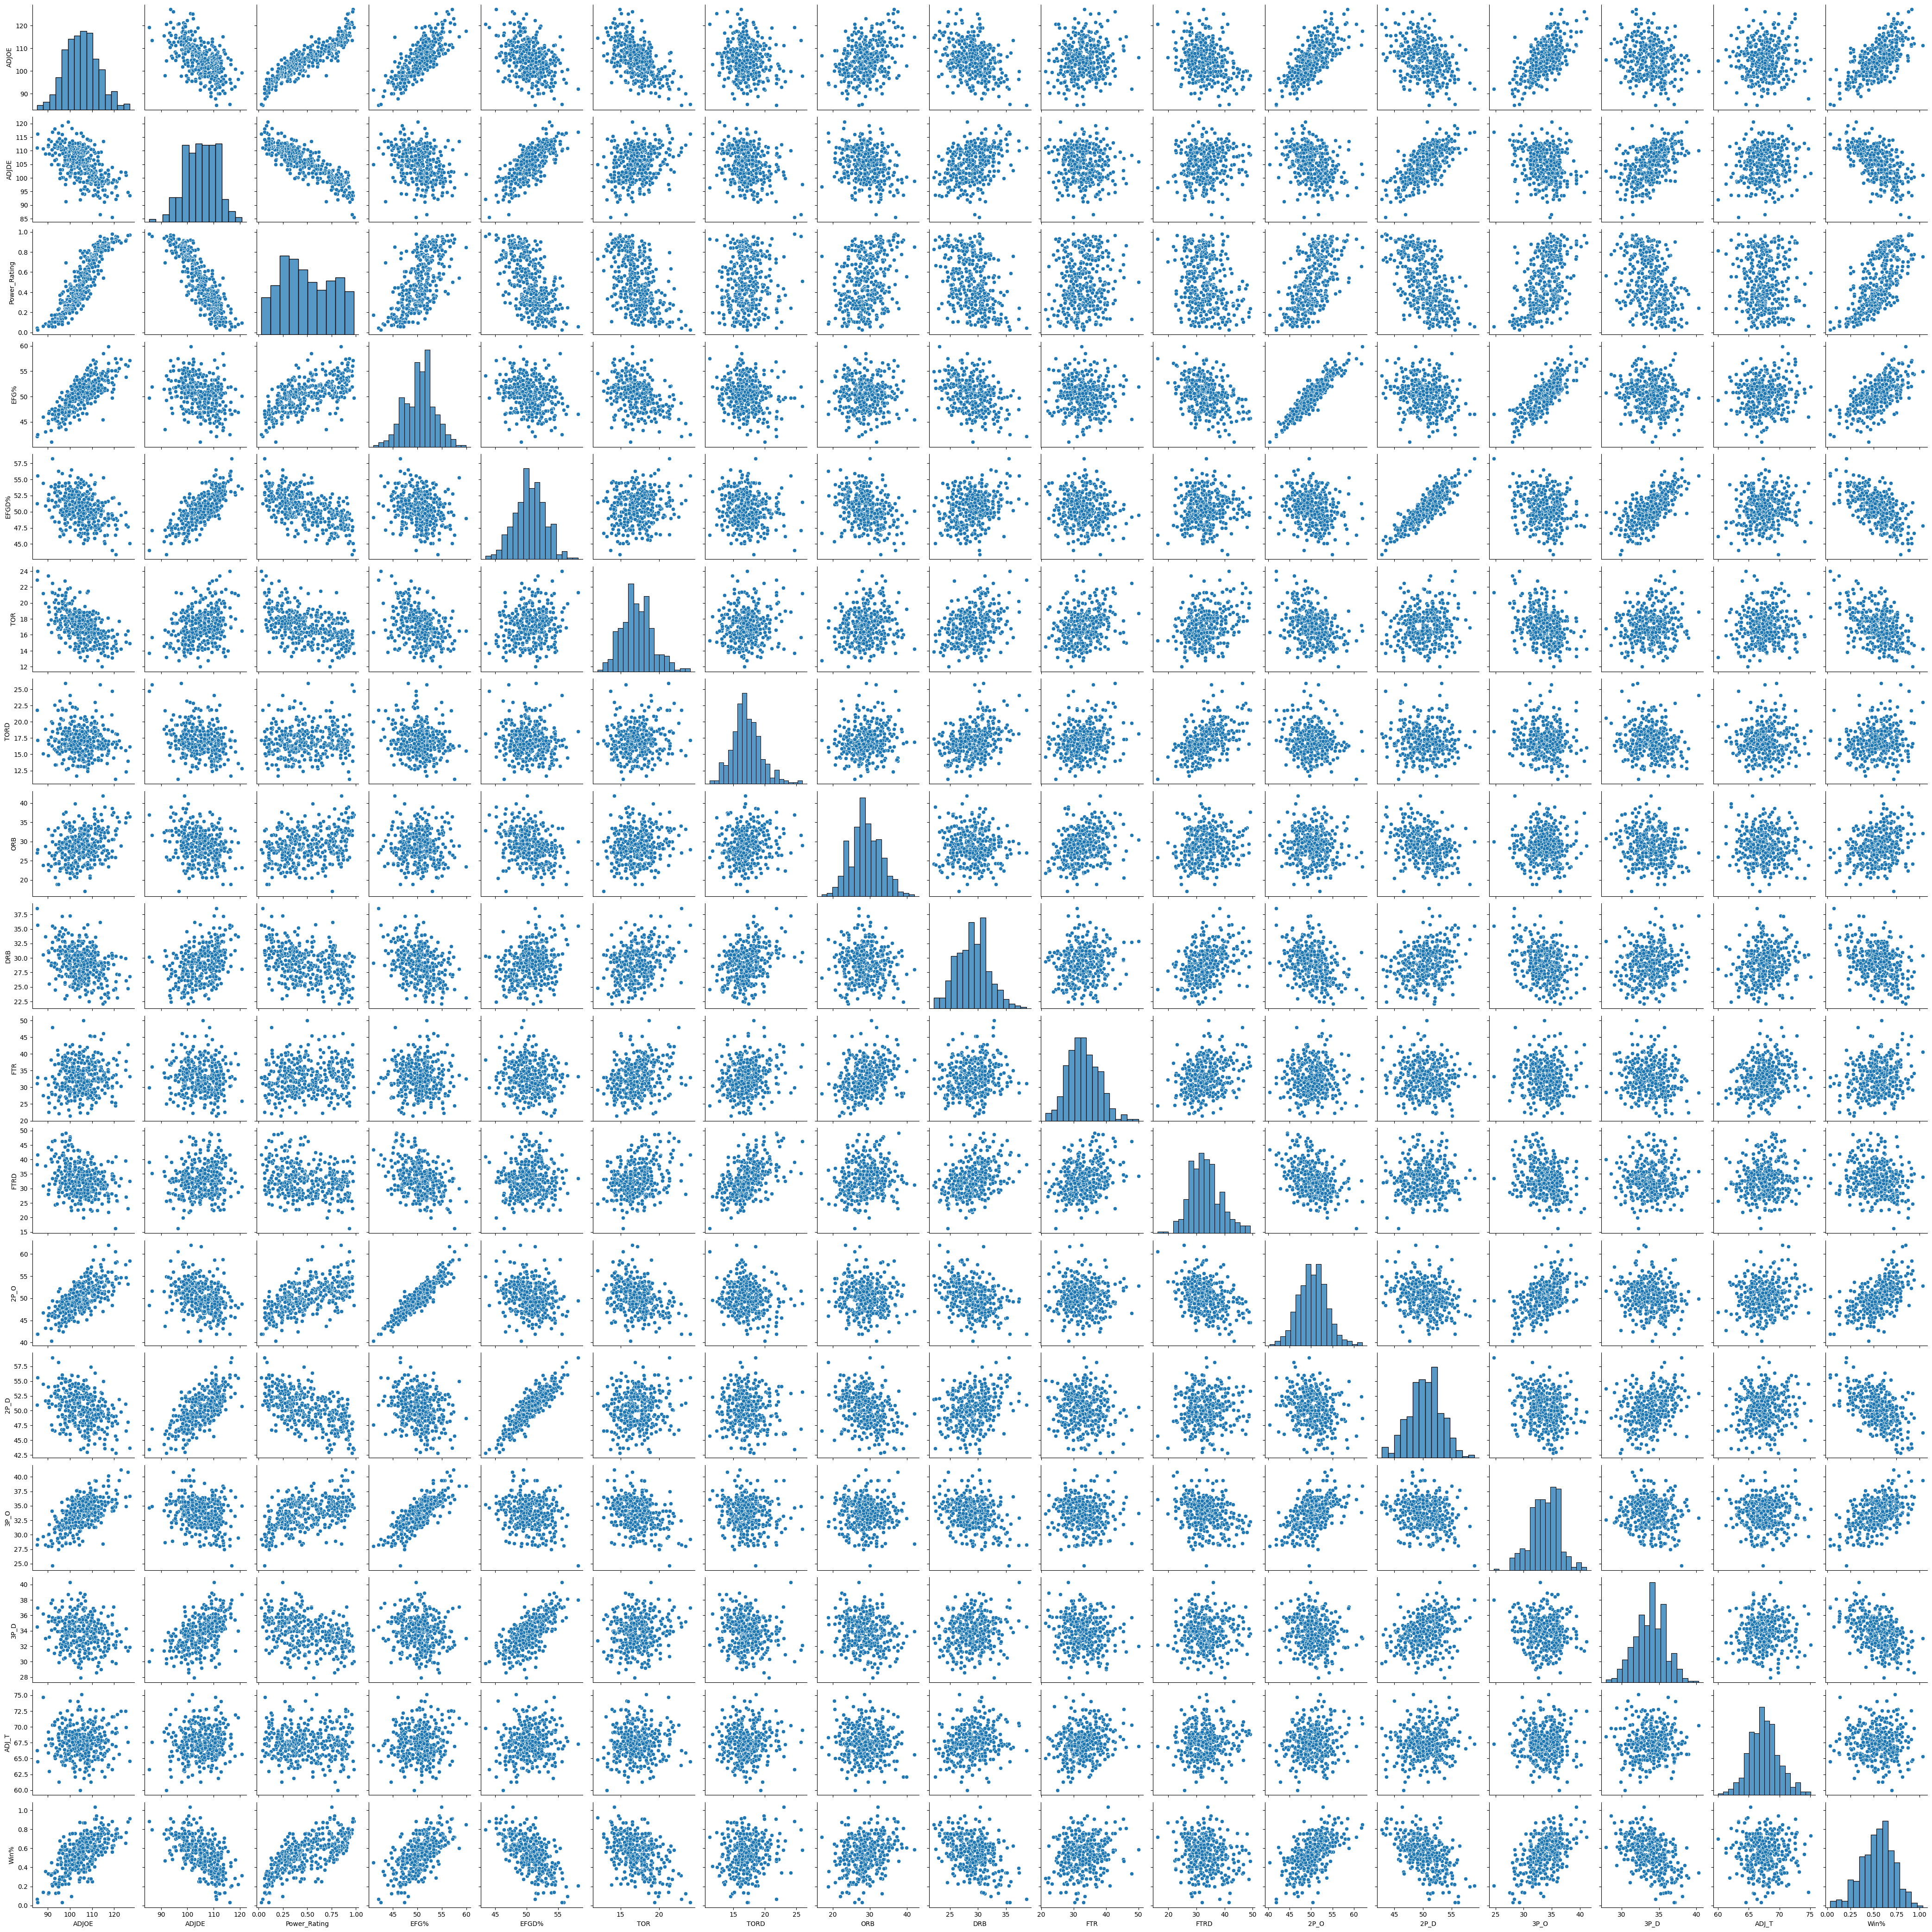

In [12]:
# Drop the categorical variable
sns.pairplot(df.drop('CONF', axis=1))
plt.show()

As you can see, there are a couple of nonlinear relationships. For example, between Power Rating and adjusted offensive efficiency as well as between Power Rating and adjusted defenseive efficiency. Next, we will take a look at the fitted values vs. residuals plot for the linear regression model that predicts our response variable given ALL of our explanatory variables that we intend to explore.

In [13]:
df.columns

Index(['CONF', 'ADJOE', 'ADJDE', 'Power_Rating', 'EFG%', 'EFGD%', 'TOR',
       'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D',
       'ADJ_T', 'Win%'],
      dtype='object')

In [14]:
# Need to get rid of % in column names for syntax to work
df.rename(columns={'EFG%': 'EFGO', 'EFGD%': 'EFGD', 'Win%': 'WinP'}, inplace=True)
# More syntax stuff for ols to work
df.rename(columns={
    '2P_O': 'TwoP_O',
    '2P_D': 'TwoP_D',
    '3P_O': 'ThreeP_O',
    '3P_D': 'ThreeP_D'
}, inplace=True)
df.columns

Index(['CONF', 'ADJOE', 'ADJDE', 'Power_Rating', 'EFGO', 'EFGD', 'TOR', 'TORD',
       'ORB', 'DRB', 'FTR', 'FTRD', 'TwoP_O', 'TwoP_D', 'ThreeP_O', 'ThreeP_D',
       'ADJ_T', 'WinP'],
      dtype='object')

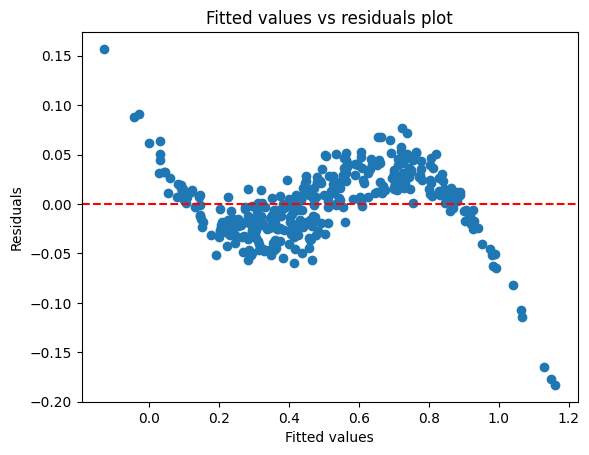

In [15]:
model = smf.ols(formula='Power_Rating~CONF+ADJOE+ADJDE+EFGO+EFGD+TOR+TORD+ORB+DRB+FTR+FTRD+TwoP_O+TwoP_D+ThreeP_O+ThreeP_D+ADJ_T+WinP', data=df).fit()
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted values vs residuals plot')
plt.show()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Power_Rating   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     331.1
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.96e-239
Time:                        22:45:44   Log-Likelihood:                 688.80
No. Observations:                 361   AIC:                            -1282.
Df Residuals:                     313   BIC:                            -1095.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5001      0.127      3.938      0.000       0.250       0.750
CONF[T.ACC]  -3.933e-05      0.016     -0.003      0.998      -0.031       0.031
CONF[T.AE]      -0.0611      0.019     -3.226      0.001      -0.098      -0.024
CONF[T.ASun]    -0.0638      0.019     -3.425      0.001      -0.100      -0.027
CONF[T.Amer]    -0.0062      0.015     -0.416      0.677      -0.035       0.023
CONF[T.B10]     -0.0088      0.017     -0.508      0.612      -0.043       0.025
CONF[T.B12]     -0.0296      0.017     -1.722      0.086      -0.063       0.004
CONF[T.BE]      -0.0397      0.018     -2.180      0.030      -0.076      -0.004
CONF[T.BSky]    -0.0666      0.019     -3.596      0.000      -0.103      -0.030
CONF[T.BSth]    -0.0470      0.018     -2.556      0.011      -0.083      -0.011
CONF[T.BW]      -0.0451      0.017     -2.680      0.008      -0.078      -0.012
CONF[T.CAA]     -0.0359      0.016     -2.229      0.027      -0.068      -0.004
CONF[T.CUSA]    -0.0479      0.018     -2.682      0.008      -0.083      -0.013
CONF[T.Horz]    -0.0453      0.019     -2.406      0.017      -0.082      -0.008
CONF[T.Ivy]     -0.0382      0.018     -2.079      0.038      -0.074      -0.002
CONF[T.MAAC]    -0.0601      0.019     -3.246      0.001      -0.097      -0.024
CONF[T.MAC]     -0.0581      0.017     -3.347      0.001      -0.092      -0.024
CONF[T.MEAC]    -0.0692      0.022     -3.155      0.002      -0.112      -0.026
CONF[T.MVC]     -0.0210      0.016     -1.335      0.183      -0.052       0.010
CONF[T.MWC]     -0.0205      0.016     -1.269      0.206      -0.052       0.011
CONF[T.NEC]     -0.0627      0.022     -2.852      0.005      -0.106      -0.019
CONF[T.OVC]     -0.0595      0.020     -2.964      0.003      -0.099      -0.020
CONF[T.P12]  -9.886e-05      0.017     -0.006      0.995      -0.033       0.033
CONF[T.Pat]     -0.0649      0.021     -3.120      0.002      -0.106      -0.024
CONF[T.SB]      -0.0422      0.016     -2.699      0.007      -0.073      -0.011
CONF[T.SC]      -0.0337      0.018     -1.912      0.057      -0.068       0.001
CONF[T.SEC]     -0.0134      0.017     -0.776      0.438      -0.047       0.021
CONF[T.SWAC]    -0.0622      0.019     -3.198      0.002      -0.100      -0.024
CONF[T.Slnd]    -0.0523      0.019     -2.702      0.007      -0.090      -0.014
CONF[T.Sum]     -0.0544      0.019     -2.832      0.005      -0.092      -0.017
CONF[T.WAC]     -0.0427      0.017     -2.540      0.012      -0.076      -0.010
CONF[T.WCC]     -0.0349      0.017     -2.067      0.040      -0.068      -0.002
ADJOE            0.0195      0.002     11.362      0.000       0.016       0.023
ADJDE           -0.0201      0.002    -11.576      0.000      -0.024      -0.017
EFGO             0.0028      0.011      0.265      0.791      -0.018       0.024
EFGD 

We do have reason to believe that some of our linear regression models may achieve a
better fit if you were to first transform one or more of our variables in our cleaned dataset because currently, the lienarity assumption is not met. If we divided the plot above into thin rectangles, many of these rectangles would have uneven number of points above and below the line.

Let's try taking the log of the ADJOE, since we saw there was nonlinear relationship in the pairplot.

In [17]:
df['Log_ADJOE'] = np.log(df['ADJOE'] + 1e-6)
df.columns

Index(['CONF', 'ADJOE', 'ADJDE', 'Power_Rating', 'EFGO', 'EFGD', 'TOR', 'TORD',
       'ORB', 'DRB', 'FTR', 'FTRD', 'TwoP_O', 'TwoP_D', 'ThreeP_O', 'ThreeP_D',
       'ADJ_T', 'WinP', 'Log_ADJOE'],
      dtype='object')

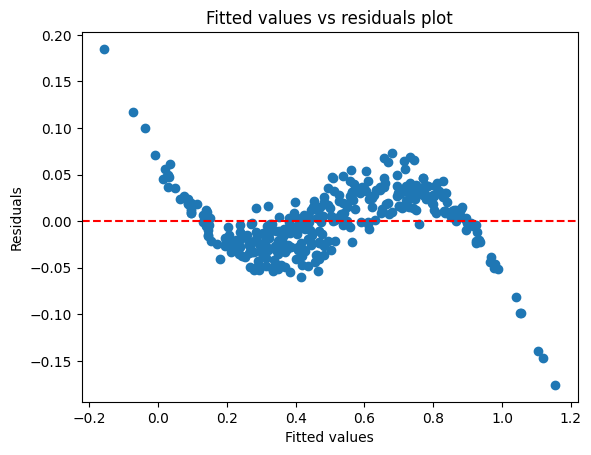

In [18]:
model = smf.ols(formula='Power_Rating~CONF+Log_ADJOE+ADJDE+EFGO+EFGD+TOR+TORD+ORB+DRB+FTR+FTRD+TwoP_O+TwoP_D+ThreeP_O+ThreeP_D+ADJ_T+WinP', data=df).fit()
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted values vs residuals plot')
plt.show()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Power_Rating   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     345.3
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          3.19e-242
Time:                        22:45:45   Log-Likelihood:                 696.23
No. Observations:                 361   AIC:                            -1296.
Df Residuals:                     313   BIC:                            -1110.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.5809      0.724    -10.468      0.000      -9.006      -6.156
CONF[T.ACC]     -0.0020      0.015     -0.129      0.897      -0.032       0.028
CONF[T.AE]      -0.0553      0.019     -2.969      0.003      -0.092      -0.019
CONF[T.ASun]    -0.0554      0.018     -3.016      0.003      -0.092      -0.019
CONF[T.Amer]    -0.0055      0.014     -0.382      0.702      -0.034       0.023
CONF[T.B10]     -0.0075      0.017     -0.443      0.658      -0.041       0.026
CONF[T.B12]     -0.0319      0.017     -1.894      0.059      -0.065       0.001
CONF[T.BE]      -0.0412      0.018     -2.313      0.021      -0.076      -0.006
CONF[T.BSky]    -0.0591      0.018     -3.232      0.001      -0.095      -0.023
CONF[T.BSth]    -0.0390      0.018     -2.150      0.032      -0.075      -0.003
CONF[T.BW]      -0.0393      0.017     -2.379      0.018      -0.072      -0.007
CONF[T.CAA]     -0.0298      0.016     -1.879      0.061      -0.061       0.001
CONF[T.CUSA]    -0.0453      0.017     -2.588      0.010      -0.080      -0.011
CONF[T.Horz]    -0.0372      0.019     -2.001      0.046      -0.074      -0.001
CONF[T.Ivy]     -0.0337      0.018     -1.866      0.063      -0.069       0.002
CONF[T.MAAC]    -0.0504      0.018     -2.756      0.006      -0.086      -0.014
CONF[T.MAC]     -0.0497      0.017     -2.899      0.004      -0.083      -0.016
CONF[T.MEAC]    -0.0502      0.022     -2.313      0.021      -0.093      -0.007
CONF[T.MVC]     -0.0200      0.015     -1.302      0.194      -0.050       0.010
CONF[T.MWC]     -0.0213      0.016     -1.341      0.181      -0.052       0.010
CONF[T.NEC]     -0.0435      0.022     -1.990      0.047      -0.086      -0.000
CONF[T.OVC]     -0.0434      0.020     -2.178      0.030      -0.083      -0.004
CONF[T.P12]     -0.0035      0.016     -0.212      0.832      -0.036       0.029
CONF[T.Pat]     -0.0487      0.021     -2.358      0.019      -0.089      -0.008
CONF[T.SB]      -0.0379      0.015     -2.473      0.014      -0.068      -0.008
CONF[T.SC]      -0.0257      0.017     -1.478      0.141      -0.060       0.009
CONF[T.SEC]     -0.0128      0.017     -0.759      0.448      -0.046       0.020
CONF[T.SWAC]    -0.0432      0.019     -2.233      0.026      -0.081      -0.005
CONF[T.Slnd]    -0.0401      0.019     -2.092      0.037      -0.078      -0.002
CONF[T.Sum]     -0.0473      0.019     -2.499      0.013      -0.085      -0.010
CONF[T.WAC]     -0.0388      0.016     -2.359      0.019      -0.071      -0.006
CONF[T.WCC]     -0.0301      0.017     -1.812      0.071      -0.063       0.003
Log_ADJOE        2.2022      0.181     12.152      0.000       1.846       2.559
ADJDE           -0.0208      0.002    -12.298      0.000      -0.024      -0.017
EFGO             0.0013      0.010      0.123      0.902      -0.019       0.022
EFGD 

This does not look much better, but we got a slightly better R-squared value so we will go with that.

In [20]:
df = df.drop('ADJOE', axis=1)
df.columns

Index(['CONF', 'ADJDE', 'Power_Rating', 'EFGO', 'EFGD', 'TOR', 'TORD', 'ORB',
       'DRB', 'FTR', 'FTRD', 'TwoP_O', 'TwoP_D', 'ThreeP_O', 'ThreeP_D',
       'ADJ_T', 'WinP', 'Log_ADJOE'],
      dtype='object')

### Interaction Terms

We now want to look at if there is a large interaction between how a given a numerical explanatory variable and a categorigal explanatory variable (Conference) impact our predicted response variable, for all pairs of Conference and a numerical variable.

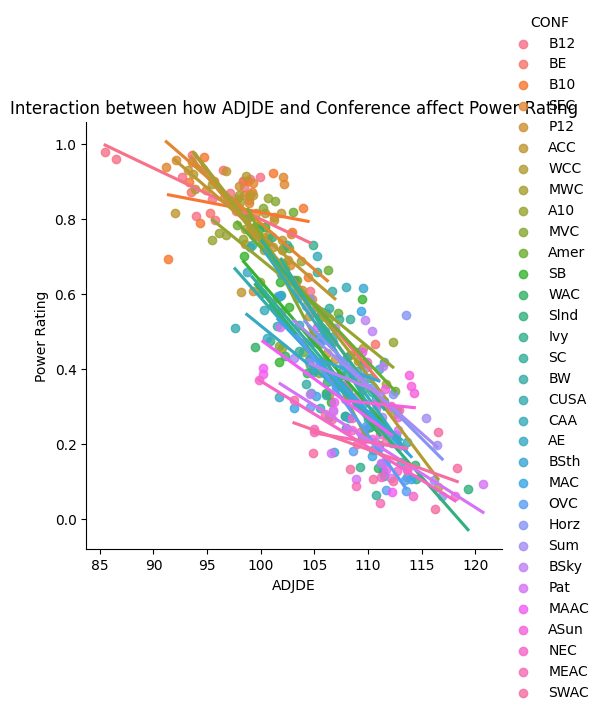

In [21]:
sns.lmplot(x='ADJDE', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('ADJDE')
plt.ylabel('Power Rating')
plt.title('Interaction between how ADJDE and Conference affect Power Rating')
plt.show()

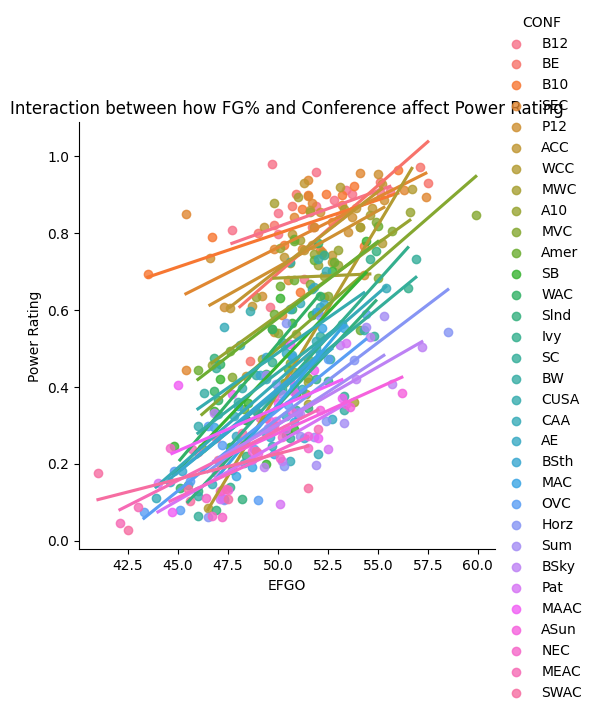

In [22]:
sns.lmplot(x='EFGO', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('EFGO')
plt.ylabel('Power Rating')
plt.title('Interaction between how FG% and Conference affect Power Rating')
plt.show()

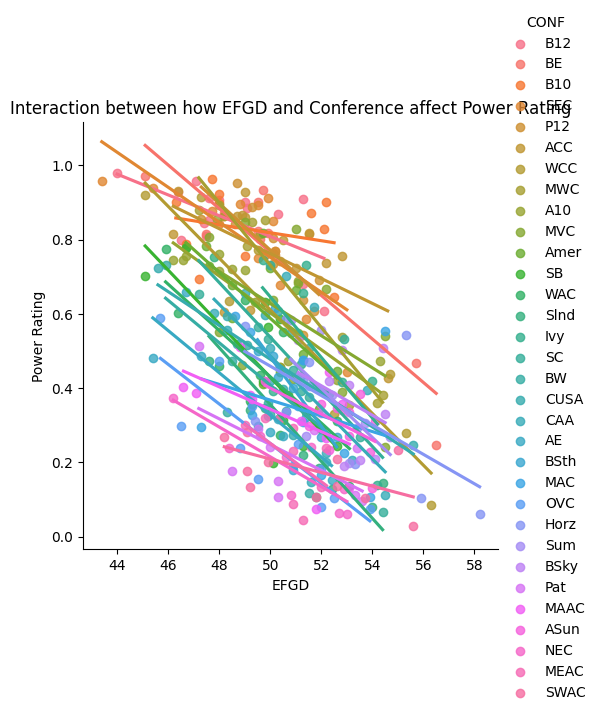

In [23]:
sns.lmplot(x='EFGD', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('EFGD')
plt.ylabel('Power Rating')
plt.title('Interaction between how EFGD and Conference affect Power Rating')
plt.show()

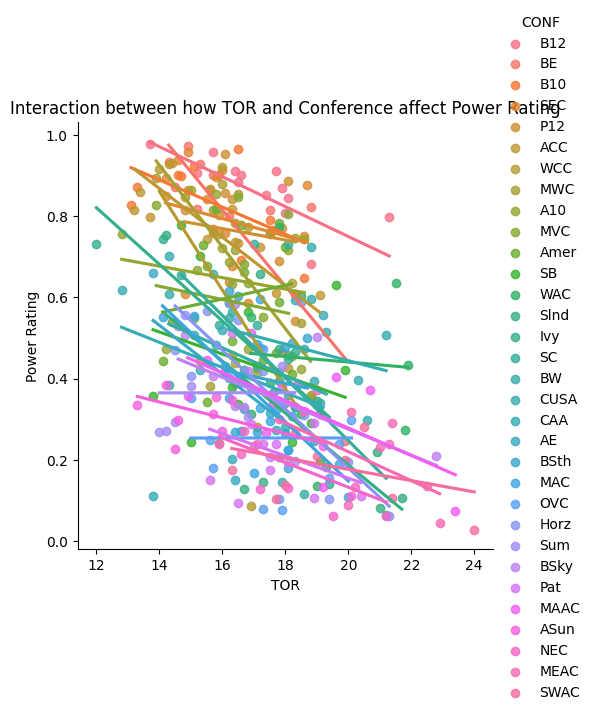

In [24]:
sns.lmplot(x='TOR', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('TOR')
plt.ylabel('Power Rating')
plt.title('Interaction between how TOR and Conference affect Power Rating')
plt.show()

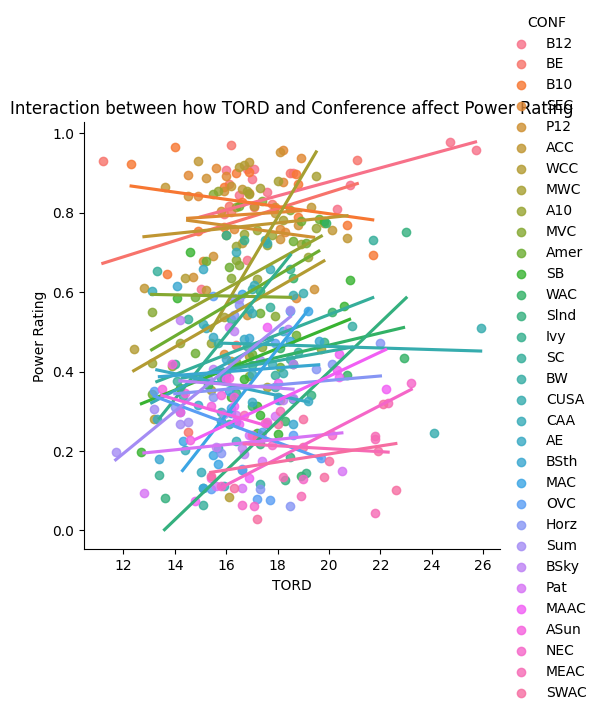

In [25]:
sns.lmplot(x='TORD', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('TORD')
plt.ylabel('Power Rating')
plt.title('Interaction between how TORD and Conference affect Power Rating')
plt.show()

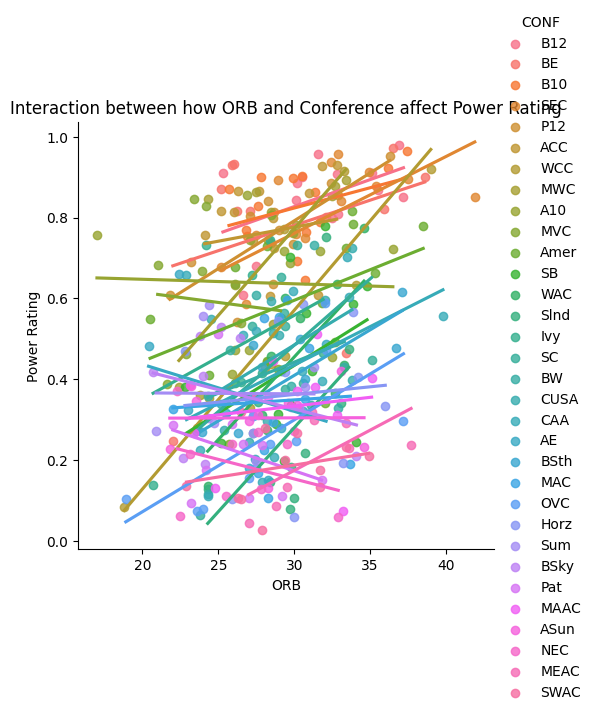

In [26]:
sns.lmplot(x='ORB', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('ORB')
plt.ylabel('Power Rating')
plt.title('Interaction between how ORB and Conference affect Power Rating')
plt.show()

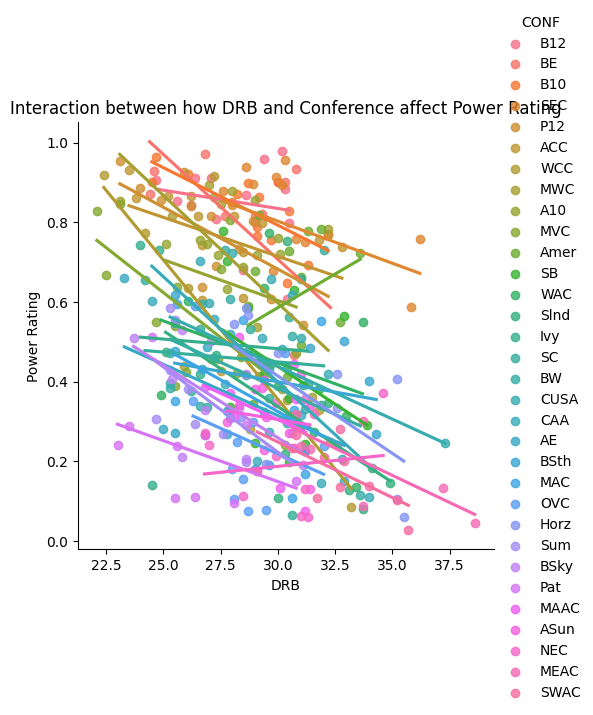

In [27]:
sns.lmplot(x='DRB', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('DRB')
plt.ylabel('Power Rating')
plt.title('Interaction between how DRB and Conference affect Power Rating')
plt.show()

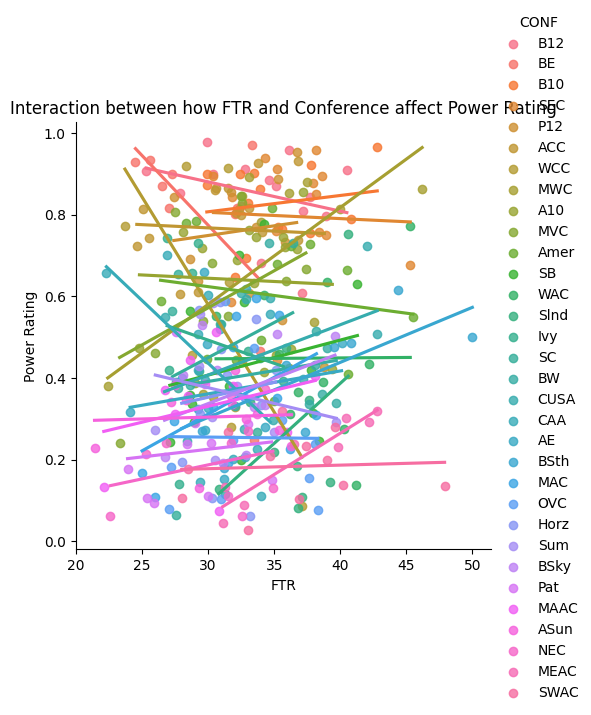

In [28]:
sns.lmplot(x='FTR', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('FTR')
plt.ylabel('Power Rating')
plt.title('Interaction between how FTR and Conference affect Power Rating')
plt.show()

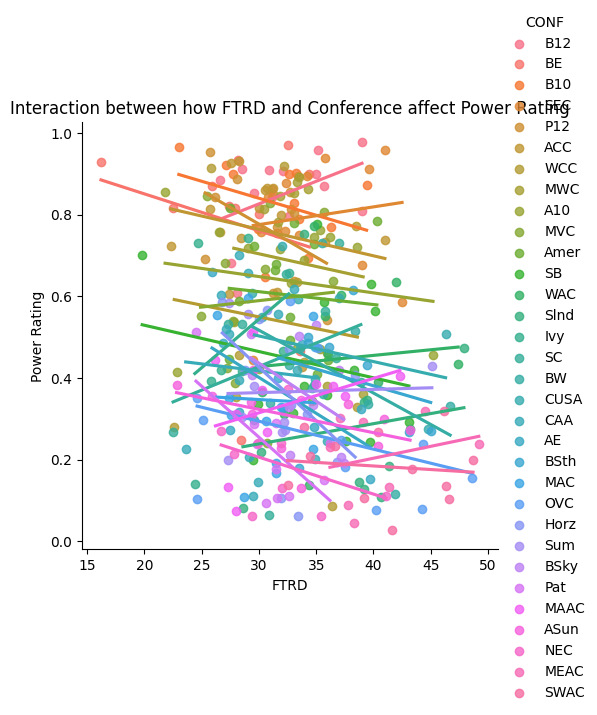

In [29]:
sns.lmplot(x='FTRD', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('FTRD')
plt.ylabel('Power Rating')
plt.title('Interaction between how FTRD and Conference affect Power Rating')
plt.show()

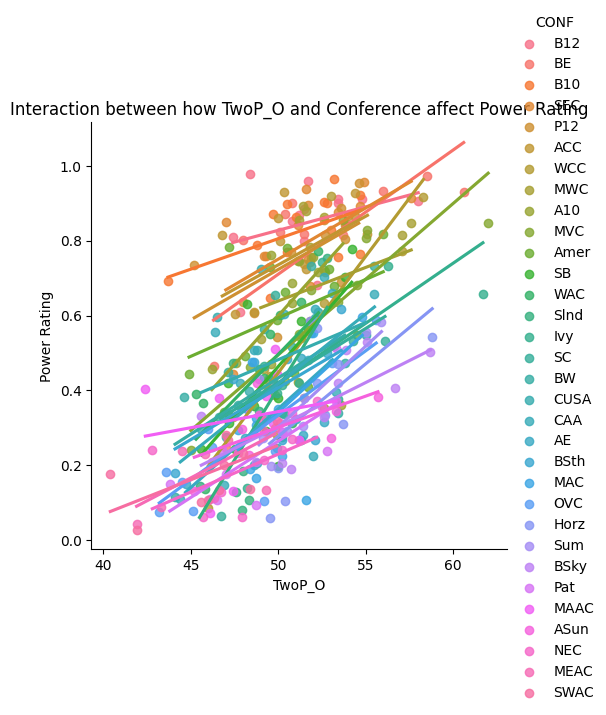

In [30]:
sns.lmplot(x='TwoP_O', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('TwoP_O')
plt.ylabel('Power Rating')
plt.title('Interaction between how TwoP_O and Conference affect Power Rating')
plt.show()

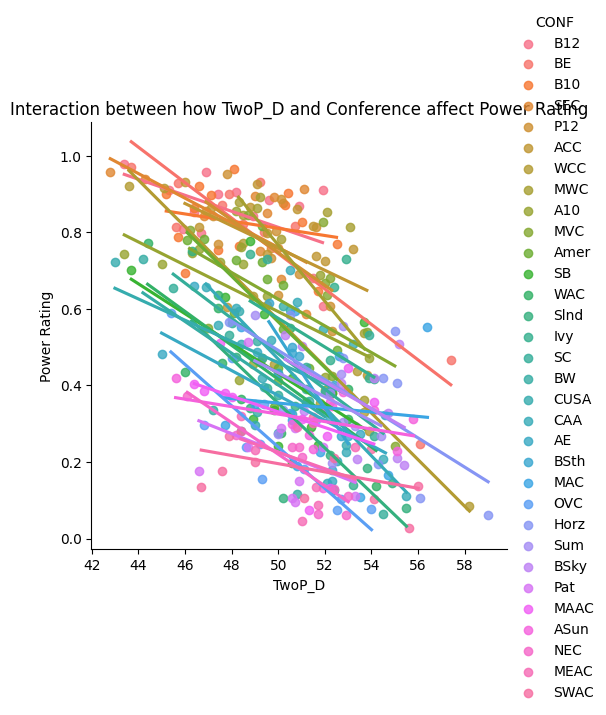

In [31]:
sns.lmplot(x='TwoP_D', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('TwoP_D')
plt.ylabel('Power Rating')
plt.title('Interaction between how TwoP_D and Conference affect Power Rating')
plt.show()

In [ ]:
sns.lmplot(x='ThreeP_D', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('ThreeP_D')
plt.ylabel('Power Rating')
plt.title('Interaction between how ThreeP_D and Conference affect Power Rating')
plt.show()

In [ ]:
sns.lmplot(x='ThreeP_O', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('ThreeP_O')
plt.ylabel('Power Rating')
plt.title('Interaction between how ThreeP_O and Conference affect Power Rating')
plt.show()

In [ ]:
sns.lmplot(x='ADJ_T', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('ADJ_T')
plt.ylabel('Power Rating')
plt.title('Interaction between how ADJ_T and Conference affect Power Rating')
plt.show()

In [ ]:
sns.lmplot(x='WinP', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('WinP')
plt.ylabel('Power Rating')
plt.title('Interaction between how WinP and Conference affect Power Rating')
plt.show()

In [ ]:
sns.lmplot(x='Log_ADJOE', y='Power_Rating', hue='CONF', ci=False, data=df)
plt.xlabel('Log_ADJOE')
plt.ylabel('Power Rating')
plt.title('Interaction between how Log(ADJOE) and Conference affect Power Rating')
plt.show()

As we can see, for every single pair of one of the numerical explanatory variables with conference, there is a large interaction between how the two impact our predicted response variable power rating, because there is at least one pair of lines with very different slopes in each of the plots.

## 5. Predictive Models

We will now create predictive models so that we can predict power ratings. First, we need to 0/1 indicator variables for our categorical explantory variable Conference using the code below.

In [ ]:
old_df = df
df = pd.get_dummies(df, drop_first=True)
df.columns

### Train-Test Split

Next, we will divide the dataset into a training and test dataset for our models to use and test. We'll use an arbitrary random state, and a test size of 20%.

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=123)

### Scaling

We'd like to try to interpret the magnitude of our slopes as representing how important the explanatory variable is when predicting the response variable, so we will z-score scale our training dataset numerical values using the training dataset column means and standard deviations, and z-score scale our test dataset numerical values using the training dataset column means and standard deviations.

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train)
train = pd.DataFrame(scaled_features, columns=train.columns)
train.head()

In [ ]:
test = pd.DataFrame(scaled_features, columns=test.columns)
test.head()

### Non-Regularized Linear Regression Full Model

The first model we will create will be the full model without regularization, using our transformed and scaled features. I also need to create feature matrix and the target variable array.

In [ ]:
X_train = train.drop('Power_Rating', axis=1)
X_test = test.drop('Power_Rating', axis=1)
y_train = train['Power_Rating']
y_test = test['Power_Rating']

In [ ]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

In [ ]:
model1.score(X_test, y_test)

### Non-Regularized Linear Regression Full Model with Interaction Terms

The second model we will create will be the full model without regularization, but with interaction terms that we identified earlier. We first need to add these terms. 

In [ ]:
train_, test_ = train_test_split(old_df, test_size=0.2, random_state=123)

In [ ]:
# Had too many predictors, so I couldn't use all of the interaction terms without an error
model2 = smf.ols(formula='Power_Rating~CONF+Log_ADJOE+ADJDE+EFGO+EFGD+TOR+TORD+ORB+DRB+FTR+FTRD+TwoP_O+TwoP_D+ThreeP_O+ThreeP_D+ADJ_T+WinP+CONF*Log_ADJOE+CONF*ADJDE+CONF*EFGO+CONF*EFGD+CONF*TOR+CONF*TORD', data=train_).fit()
model2.summary()

In [ ]:
test_predictions = model2.predict(test_)
test_r_squared = r2_score(test_['Power_Rating'], test_predictions)
test_r_squared

### Feature Selection: Regularization

The next model we will use will be the regularized Lasso linear regression model. We'll try several different values of lambda to see which leads to the highest test R^2 value.

In [ ]:
temp_list=[]
for alpha in np.arange(0, 0.4005, 0.005):
    lasso_model = Lasso(alpha=alpha, max_iter=1000)
    lasso_model.fit(X_train, y_train)
    temp_list.append([alpha, lasso_model.score(X_test, y_test)])
    
lasso_df = pd.DataFrame(temp_list, columns=['lambda', 'R^2'])
lasso_df.head()

In [ ]:
plt.plot(lasso_df['lambda'].values, lasso_df['R^2'].values)
plt.xlabel('lambda')
plt.ylabel('Test R^2')
plt.show()

In [ ]:
lasso_df[lasso_df['R^2'] == lasso_df['R^2'].max()]

The max value is at the lambda value of 0, which is just the same as the non-regularized model without interaction terms.

Now we're interested to see if a Ridge regression model will lead to a better test R^2 value. We will test this at many different values for lambda.

In [ ]:
temp_list=[]
for alpha in np.arange(0, 401, 1):
    ridge_model = Ridge(alpha=alpha, max_iter=1000)
    ridge_model.fit(X_train, y_train)
    temp_list.append([alpha, ridge_model.score(X_test, y_test)])
    
ridge_df = pd.DataFrame(temp_list, columns=['lambda', 'R^2'])
ridge_df.head()

In [ ]:
plt.plot(ridge_df['lambda'].values, ridge_df['R^2'].values)
plt.xlabel('lambda')
plt.ylabel('Test R^2')
plt.show()

In [ ]:
ridge_df[ridge_df['R^2'] == ridge_df['R^2'].max()]

It looks like alpha being 0 also leads to the highest test R^2 value for the Ridge regression.

## 6. Best Model Discussion

### Equation

We will write out the equation for the model with the highest test R^2 value, which was the full non-regularized model. 

In [ ]:
intercept = model1.intercept_
coefficients = model1.coef_

print(f'Intercept: {intercept}')

feature_names = X_train.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model1.coef_})

coef_df

Too long to write out, but the full equation is the intercept + each feature * slope value coefficient.

### Test Dataset Fit

The overall fit for this model is extremely good as the test R^2 value is 0.98, which is very high.

### Overfitting Explanatory Variables

Since the best model was the full model without regularization, this suggests that there weren't any response variables overfitting the model.

### Multicollinearity

Now, we want to see if there is multicollinearity among explanatory variables.

In [ ]:
df.drop('Power_Rating', axis=1).corr()

There are some highly correlated response variables. ADJDE and EFGD have a high correlation of 0.76, so there could be an issue with multicollinearity with the model.

### Slope Interpretations

Since we scaled the features, we should be able to interpret the magnitudes of the slopes as indicating how important the
corresponding explanatory variable are when it comes to predicting our response variable in a linear regression model. The adjusted offenseive efficiency and the adjusted defensive efficiency are have the highest slope magnitudes and are thus the most important response variables in predicting power rating.

## 7. Conclusion

### Recommendation

I would recommend our best model to be used by the person that we mentioned in our motivation, the Illinois basketball fan, because the model has a really good fit. The fan could look at the slopes and see what is most important contributor to the power rating.

### Shortcomings/Caveats

We do not know FOR SURE that our chosen best model will yield the HIGHEST possible test R^2 outof all possible models that we could make with this dataset. For example, there are infinitely many values of alpha that we could have used in our regularized model. We also didn't try an elastic net model or other types of models that could have had higher test R^2 values. A more complete analysis may have included test various elastic net models to see if that could have performed better than the models we used. Other shortcomings is the potential for a multicollinearity issue that we explored earlier that could have negatively affected the model. We also had a limited amount of data in the dataset, and a very large number of explanatory variables.

### Future Work

Based on the results of this analysis, one idea I might have for future work is to predict the power ratings of new teams in the upcoming basketball season of next year based on transfers and new players for each team to try to see what the best teams could be.